In [67]:
from __future__ import annotations
import numpy as np

unexpanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/component development/mergeLogic/unmerged_labels_prev.npy")
expanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/component development/mergeLogic/unmerged_labels.npy")

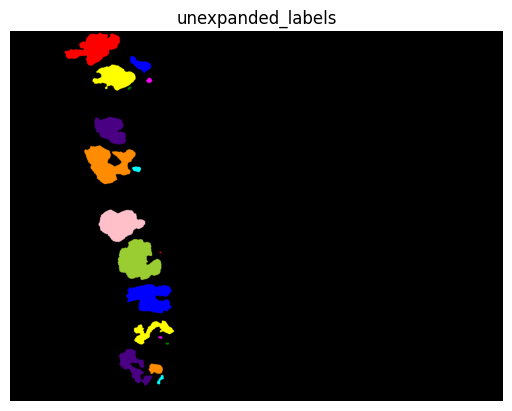

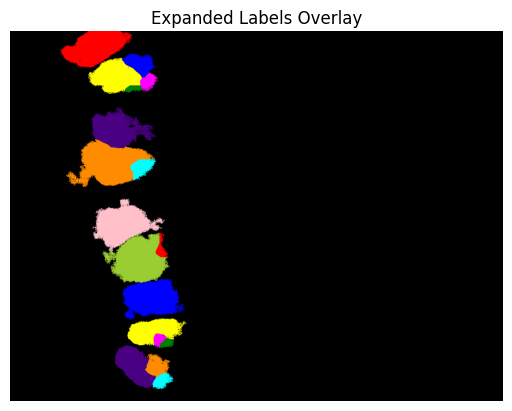

In [58]:

from skimage.color import label2rgb
from matplotlib import pyplot as plt

colored = label2rgb(unexpanded_labels, bg_label=0)

plt.imshow(colored)
plt.title("unexpanded_labels")
plt.axis('off')
plt.show()

colored = label2rgb(expanded_labels, bg_label=0)
plt.imshow(colored)
plt.title("Expanded Labels Overlay")
plt.axis('off')
plt.show()


1) Basic stats & adjacency

In [59]:
import numpy as np
from skimage.measure import regionprops, perimeter
from skimage.morphology import dilation, rectangle
from itertools import combinations
from collections import defaultdict

def compute_stats_and_adjacency(label_img):
    props    = {r.label: r for r in regionprops(label_img)}
    perims   = {lbl: perimeter(label_img == lbl) for lbl in props}
    centroids= {lbl: props[lbl].centroid for lbl in props}
    areas    = {lbl: props[lbl].area     for lbl in props}
    
    # adjacency: shared perimeter between i↔j
    shared = defaultdict(lambda: defaultdict(int))
    for lbl in props:
        mask = label_img == lbl
        dil  = dilation(mask, rectangle(3,3))
        neighs = set(np.unique(label_img[dil])) - {0, lbl}
        for n in neighs:
            shared_p = int(np.logical_and(dil, label_img==n).sum())
            shared[lbl][n] = shared_p
            shared[n][lbl] = shared_p
    
    return props, perims, centroids, areas, shared




2) Enumerate possible combinations
We’ll only consider connected subsets up to size k (you can pick k=2 or 3 to start). For each label ℓ, collect all neighbor‐only combos that include ℓ:

In [60]:
def neighbor_combinations(shared, max_k=2):
    """
    For each label ℓ, return a list of combos it might join.
      - Always include (ℓ,)  → “merge into self”
      - Then include every direct neighbor pair (ℓ, n)
      - (Optional) if max_k>2, you can add cliques, but we’ll stick to pairs.
    """
    # shared is the dict from above
    combos = defaultdict(list)   # combos[ℓ] = list of tuples (ℓ, …)
    for lbl, neighs in shared.items():
        # 1) self-merge option
        combos[lbl].append((lbl,))

        # 2) each direct neighbor
        # you can take k=1 (just each singleton), plus k=2 pairs, etc.
        pool = [lbl] + list(neighs.keys())
        for k in range(2, max_k+1):
            for combo in combinations(pool, k):
                if lbl in combo and all(any(n in combo for n in shared[m]) for m in combo):
                    combos[lbl].append(tuple(sorted(combo)))
    return combos


3) Score each (label, combo)
For each label ℓ and each combo C:

ratio1 = (shared perimeter of ℓ to C∖{ℓ}) ÷ (perimeter_exposed = perim(ℓ) – shared_sum)

ratio2 = (1 / distance(centroid(ℓ), COM(C))) × ( area(C) / perimeter(C) )

where

```
COM(C) = weighted average of centroids by area  
area(C) = sum of areas  
perimeter(C) = sum of perimeters
```

In [86]:


import math

def score_label_combo(lbl, combo, perims, cents, areas, shared):
    P = perims[lbl]

    # ─── No-op case: (lbl,) shares P/2, exposes P/2 ───
    if len(combo) == 1:
        shared_sum = P / 10.0
        exposed    = P - shared_sum            # also P/2
        ratio1     = shared_sum / (exposed + 1e-8)  # =1
        ratio2     = 0.0                       # de-emphasize self-merge
        return ratio1, ratio2

    # ─── Real merge candidates ───
    shared_sum = sum(shared[lbl][n] for n in combo if n != lbl)
    exposed    = P - shared_sum
    ratio1     = shared_sum / (exposed + 1e-8)

    # Compute merged COM, area, perim
    total_area  = sum(areas[n] for n in combo)
    total_perim = sum(perims[n] for n in combo)

    com_y = sum(areas[n] * cents[n][0] for n in combo) / total_area
    com_x = sum(areas[n] * cents[n][1] for n in combo) / total_area

    dy   = cents[lbl][0] - com_y
    dx   = cents[lbl][1] - com_x
    dist = math.hypot(dy, dx) + 1e-8

    ratio2 = (1.0 / dist) * (total_area / (total_perim + 1e-8))
    return ratio1, ratio2




4) Pick the best merge partner for each ℓ

In [62]:
def build_swallow_map(combos, perims, centroids, areas, shared):
    swallow = {}   # swallow[lbl] = label it will merge into
    for lbl, combo_list in combos.items():
        best_score = (-1, -1)
        best_combo = None
        for combo in combo_list:
            sc = score_label_combo(lbl, combo, perims, centroids, areas, shared)
            if sc > best_score:
                best_score, best_combo = sc, combo

        if best_combo:
            # pick the “dominant” blob in that combo: max area×perim
            rep = max(best_combo, key=lambda n: areas[n]*perims[n])
            if rep != lbl:
                swallow[lbl] = rep
    return swallow


5) Apply the mapping

In [63]:
def apply_swallow(label_img, swallow_map):
    out = label_img.copy()
    for small, big in swallow_map.items():
        out[out==small] = big
    return out


END to end

In [82]:
props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)
combos = neighbor_combinations(shared, max_k=2)
swallow = build_swallow_map(combos, perims, cents, areas, shared)
merged  = apply_swallow(expanded_labels, swallow)


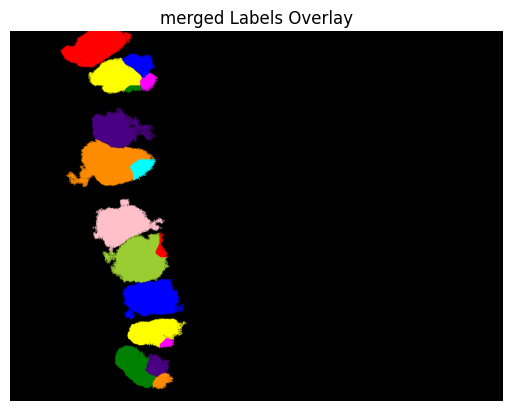

In [87]:
colored = label2rgb(merged, bg_label=0)
plt.imshow(colored)
plt.title("merged Labels Overlay")
plt.axis('off')
plt.show()

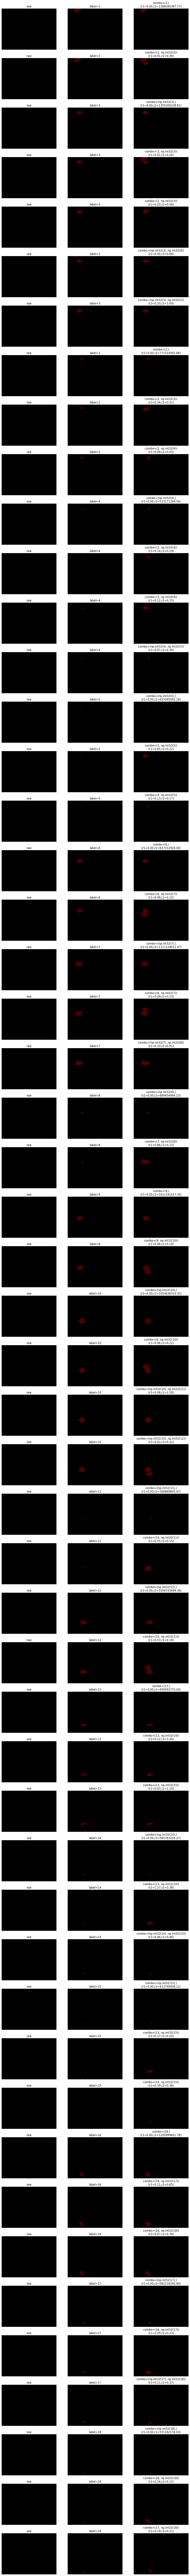

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

def render_merge_analysis(
    expanded_labels: np.ndarray,
    combos: dict[int, list[tuple[int, ...]]],
    perims: dict[int, float],
    cents: dict[int, tuple[float, float]],
    areas: dict[int, int],
    shared: dict[int, dict[int, int]],
    score_fn,
    raw_img: np.ndarray | None = None,
    figsize_per_row: tuple[int,int] = (12, 3),
):
    """
    For every label ℓ and every candidate combo C ∋ ℓ, plot:
      [ raw | ℓ-overlay | (ℓ merged with C\{ℓ})-overlay ]
    and print (ratio1, ratio2) above each row.

    Parameters
    ----------
    expanded_labels : 2D label array from your watershed
    combos          : mapping ℓ → list of tuples (ℓ, …)
    perims, cents, areas, shared : same dicts as before
    score_fn        : function(lbl, combo, …) → (ratio1, ratio2)
    raw_img         : H×W×3 or H×W image, or None → will use black background
    figsize_per_row : size of each row in inches
    """
    n_plots = sum(len(c_list) for c_list in combos.values())
    fig = plt.figure(constrained_layout=True, figsize=(figsize_per_row[0], figsize_per_row[1]*n_plots))
    gs = fig.add_gridspec(n_plots, 3)

    row = 0
    # prepare a black background if raw_img is empty
    if raw_img is None or np.all(raw_img == 0):
        bg = np.zeros((*expanded_labels.shape, 3), dtype=np.uint8)
    else:
        # if grayscale, stack to RGB
        if raw_img.ndim == 2:
            bg = np.stack([raw_img]*3, axis=-1)
        else:
            bg = raw_img.copy()

    for lbl, combo_list in combos.items():
        for combo in combo_list:
            ratio1, ratio2 = score_fn(lbl, combo, perims, cents, areas, shared)
            # 1) raw
            ax0 = fig.add_subplot(gs[row, 0])
            ax0.imshow(bg)
            ax0.set_title("raw")
            ax0.axis("off")

            # 2) ℓ overlay
            mask_lbl = (expanded_labels == lbl)
            ov0 = label2rgb(mask_lbl.astype(int), image=bg, bg_label=0)
            ax1 = fig.add_subplot(gs[row, 1])
            ax1.imshow(ov0)
            ax1.set_title(f"label={lbl}")
            ax1.axis("off")

            # 3) merged overlay
            merged = expanded_labels.copy()
            for l in combo:
                if l != lbl:
                    merged[merged == l] = lbl
            # show only the merged ℓ-region (others masked out)
            merged_mask = (merged == lbl)
            ov1 = label2rgb(merged_mask.astype(int), image=bg, bg_label=0)
            ax2 = fig.add_subplot(gs[row, 2])
            ax2.imshow(ov1)
            ax2.set_title(f"combo={combo}\n(r1={ratio1:.2f},r2={ratio2:.2f})")
            ax2.axis("off")

            row += 1

    plt.show()
    
def auto_merge_pipeline(
    expanded_labels: np.ndarray,
    raw_img: np.ndarray | None = None,
    max_k: int = 2
):
    """
    Runs the full merge-logic pipeline:
      1. compute_stats_and_adjacency
      2. neighbor_combinations
      3. build_swallow_map
      4. apply_swallow

    Returns
    -------
    merged_labels : np.ndarray
      The label image after one round of optimal, pairwise greedy merges.
    swallow_map : dict[int,int]
      Mapping small_label → chosen big_label.
    combos : dict[int, list[tuple[int,...]]]
      All candidate combos per label.
    perims, cents, areas, shared : the stats dicts for further analysis.
    """
    # 1) stats + adjacency
    props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)

    # 2) combos (including the self-merge option)
    combos = neighbor_combinations(shared, max_k=max_k)

    # 3) decide who swallows whom
    swallow = build_swallow_map(combos, perims, cents, areas, shared)

    # 4) apply
    merged = apply_swallow(expanded_labels, swallow)

    return merged, swallow, combos, perims, cents, areas, shared

# assume you’ve already got `expanded_labels` and (optionally) your `red_image`

merged, swallow_map, combos, perims, cents, areas, shared = auto_merge_pipeline(
    expanded_labels,
    raw_img=None,  # or your raw image array
    max_k=2
)



# Or run the detailed render:
render_merge_analysis(
    expanded_labels,
    combos,
    perims,
    cents,
    areas,
    shared,
    score_label_combo
)


In [76]:
# assume you already have:
# combos, perims, cents, areas, shared from auto_merge_pipeline

print(f"{'Label':>5}  {'Combo':>15}   {'ratio1':>8}   {'ratio2':>8}   shared_sum  exposed  dist_to_COM")
for lbl, combo_list in combos.items():
    for combo in combo_list:
        # compute raw stats
        shared_sum = sum(shared[lbl].get(n, 0) for n in combo if n!=lbl)
        exposed    = perims[lbl] - shared_sum
        # compute distance to COM
        com_y = sum(areas[n]*cents[n][0] for n in combo) / sum(areas[n] for n in combo)
        com_x = sum(areas[n]*cents[n][1] for n in combo) / sum(areas[n] for n in combo)
        dy = cents[lbl][0] - com_y
        dx = cents[lbl][1] - com_x
        dist = (dy*dy + dx*dx)**0.5

        # get the ratios
        r1, r2 = score_label_combo(lbl, combo, perims, cents, areas, shared)

        print(f"{lbl:5d}   {str(combo):15s}   {r1:8.3f}   {r2:8.3f}   {shared_sum:10d}   {exposed:8.1f}   {dist:8.2f}")


Label            Combo     ratio1     ratio2   shared_sum  exposed  dist_to_COM
    1   (1,)                 0.000   1389285367.765            0      783.4       0.00
    1   (1, np.int32(3))      0.008      0.358            6      777.4      38.44
    3   (np.int32(3),)       0.000   1355300108.612            0      592.8       0.00
    3   (1, np.int32(3))      0.010      0.264            6      586.8      52.07
    3   (2, np.int32(3))      0.203      0.564          100      492.8      19.87
    3   (np.int32(3), np.int32(4))      0.048      0.894           27      565.8      12.44
    3   (np.int32(3), np.int32(5))      0.100      3.044           54      538.8       3.88
    2   (2,)                 0.000   771514581.663            0      395.1       0.00
    2   (2, np.int32(3))      0.339      0.214          100      295.1      52.38
    2   (2, np.int32(4))      0.082      0.429           30      365.1      15.84
    4   (np.int32(4),)       0.000   533171284.543            0   